In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('DataSetCoursework_AMA.txt', sep=r'\s+', header=None) # Loading the data in pandas dataframe
data.head() # Column from 0 to 5 represent record of the spike, column 6 represent the behaviour column 7 represent trial number

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [13]:
# Checking for missing values and information of the data.
print(f' The total length of the data : {len(data)}')
print(data.isna().sum()) # It shows there is no missing values.

 The total length of the data : 4836
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4836 entries, 0 to 4835
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4836 non-null   float64
 1   1       4836 non-null   float64
 2   2       4836 non-null   float64
 3   3       4836 non-null   float64
 4   4       4836 non-null   float64
 5   5       4836 non-null   float64
 6   6       4836 non-null   float64
 7   7       4836 non-null   float64
dtypes: float64(8)
memory usage: 302.4 KB
None
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


In [14]:
bin_size = 0.01 # Provided by the dataset
num_of_rows = data.shape[0]
time_duration = num_of_rows * bin_size
print(f'The total duration of the data is {time_duration:.2f} seconds')

The total duration of the data is 48.36 seconds


In [15]:
print(np.sum(data[data.iloc[:, 0] != 0][0]))
data.nunique() # The number of uniques across each column.

17.0


0     2
1     2
2     3
3     3
4     2
5     3
6     4
7    20
dtype: int64

<Axes: >

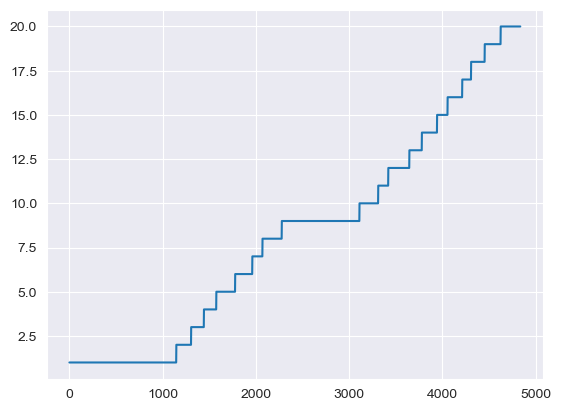

In [16]:
n_trials = data.iloc[:, -1]
n_trials.plot() # Plotting the n_trials to see the pattern of trials,

In [17]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
lda = LinearDiscriminantAnalysis()
loo = LeaveOneOut()
spikes = data.iloc[:, :-2].values
target = data.iloc[:, -2].values
X_train, X_test, y_train, y_test = train_test_split(spikes, target, test_size=0.2, random_state=42)
#scores = cross_val_score(lda, X_train, y_train, cv=LeaveOneOut())
import time
start_time = time.time()
scores = cross_val_score(lda, spikes, target, cv=loo, scoring='accuracy')
end_time = time.time()
print(f'Mean accuracy: {scores.mean():.3f}')
print(f'Time taken: {end_time - start_time:.2f} seconds')
lda2 = LinearDiscriminantAnalysis()
lda2.fit(X_train, y_train)

train_score = lda2.score(X_train, y_train)
test_score = lda2.score(X_test, y_test)
print(f'Test score: {test_score:.3f}')
print(f'Train score: {train_score:.3f}')

Mean accuracy: 0.419
Time taken: 6.19 seconds
Test score: 0.419
Train score: 0.417


In [18]:
def rates1_calculate(spikes, window_size, bin_size=0.01):
    '''
    This function calculates the firing rate of the neurons, by explicitly using the window size.
    Produced By Emily B-B, Bournemouth University edited to fit our assignment requirements.

    :param spikes: the neuron spike train (numpy array or loaded from a file)
    :param window_size: size of the time window in seconds (e.g., 0.2 seconds)
    :param bin_size: size of each time snapshot (e.g., 0.01 seconds per row, provided by the dataset)
    :return: The firing rate of the neurons and a function for plotting
    '''
    if spikes is None:  # If no spike data is provided, load from the default file
        spikes = np.loadtxt('DataSetCoursework_AMA.txt')

    # Extract last column as the trial number
    trial_num = spikes[:, -1]  # Stores trial identifiers for each row

    # Remove last two columns (to focus only on spike data)
    spikes = spikes[:, :-2]

    # Get the dimensions: n = number of time steps, m = number of neurons
    n, m = spikes.shape

    # Create a time vector based on bin_size and number of rows
    times = np.arange(0, n * bin_size, bin_size)

    # Calculate window steps: the number of rows corresponding to the given window size
    window_steps = round(window_size / bin_size)

    # Initialize a rate matrix of zeros
    rate = np.zeros((n, m))

    # Loop through each neuron
    for j in range(m):
        smoothed = []

        # For each neuron, apply a sliding window technique to calculate firing rate
        for i in range(n - window_steps + 1):  # Loop over time steps
            # Select the spike count data for the current time window
            spikes_one_neuron = spikes[i:i + window_steps, j]

            # Compute the firing rate: sum of spikes in the window divided by window size
            rate_in_this_window = np.sum(spikes_one_neuron) / window_size

            # Append the calculated rate to the smoothed list (firing rate over time)
            smoothed.append(rate_in_this_window)

        # To match the shape of the original data, repeat the last value for the remaining steps
        smoothed.extend([smoothed[-1]] * (window_steps - 1))

        # Store the smoothed rates for the current neuron into the rate matrix
        rate[:, j] = smoothed

    # Add trial number as the last column of the rate matrix
    rate = np.column_stack((rate, trial_num))

    # Define the plotting function
    def plot_rate():
        '''
        This function plots the spike train and firing rate for each neuron.
        It uses the `spikes` and `rate` calculated in the parent function.
        '''
        fig, axs = plt.subplots(m, 2, figsize=(10, m * 2))  # Create subplots for all neurons
        for j in range(m):  # Loop to plot for each neuron
            # Plot spike train on the left
            axs[j, 0].plot(times, spikes[:, j], 'b')
            axs[j, 0].set_title(f'Neuron {j + 1}')  # Title for the subplot
            axs[j, 0].set_ylabel('Spikes')  # Y-axis label
            axs[j, 0].set_xlabel('Time (s)')  # X-axis label

            # Plot firing rate on the right
            axs[j, 1].plot(times, rate[:, j], 'r')
            axs[j, 1].set_title(f'Neuron {j + 1} rate')  # Title for the subplot
            axs[j, 1].set_ylabel('Spikes/sec')  # Y-axis label
            axs[j, 1].set_xlabel('Time (s)')  # X-axis label

        plt.tight_layout()  # Adjust layout for readability
        plt.show()  # Display the plots

    # Return both the rate matrix and the plot logic
    return rate, plot_rate


In [19]:
spikes = np.loadtxt('DataSetCoursework_POG.txt')
rate, plot_rate = rates1_calculate(spikes=spikes, window_size=1.7,)
rate

array([[ 0.58823529,  1.76470588,  0.58823529, ...,  1.17647059,
         2.35294118,  1.        ],
       [ 0.58823529,  1.76470588,  0.58823529, ...,  1.17647059,
         2.35294118,  1.        ],
       [ 0.58823529,  1.76470588,  0.58823529, ...,  1.17647059,
         2.35294118,  1.        ],
       ...,
       [ 0.58823529,  0.        ,  0.58823529, ...,  4.11764706,
         0.58823529, 20.        ],
       [ 0.58823529,  0.        ,  0.58823529, ...,  4.11764706,
         0.58823529, 20.        ],
       [ 0.58823529,  0.        ,  0.58823529, ...,  4.11764706,
         0.58823529, 20.        ]])

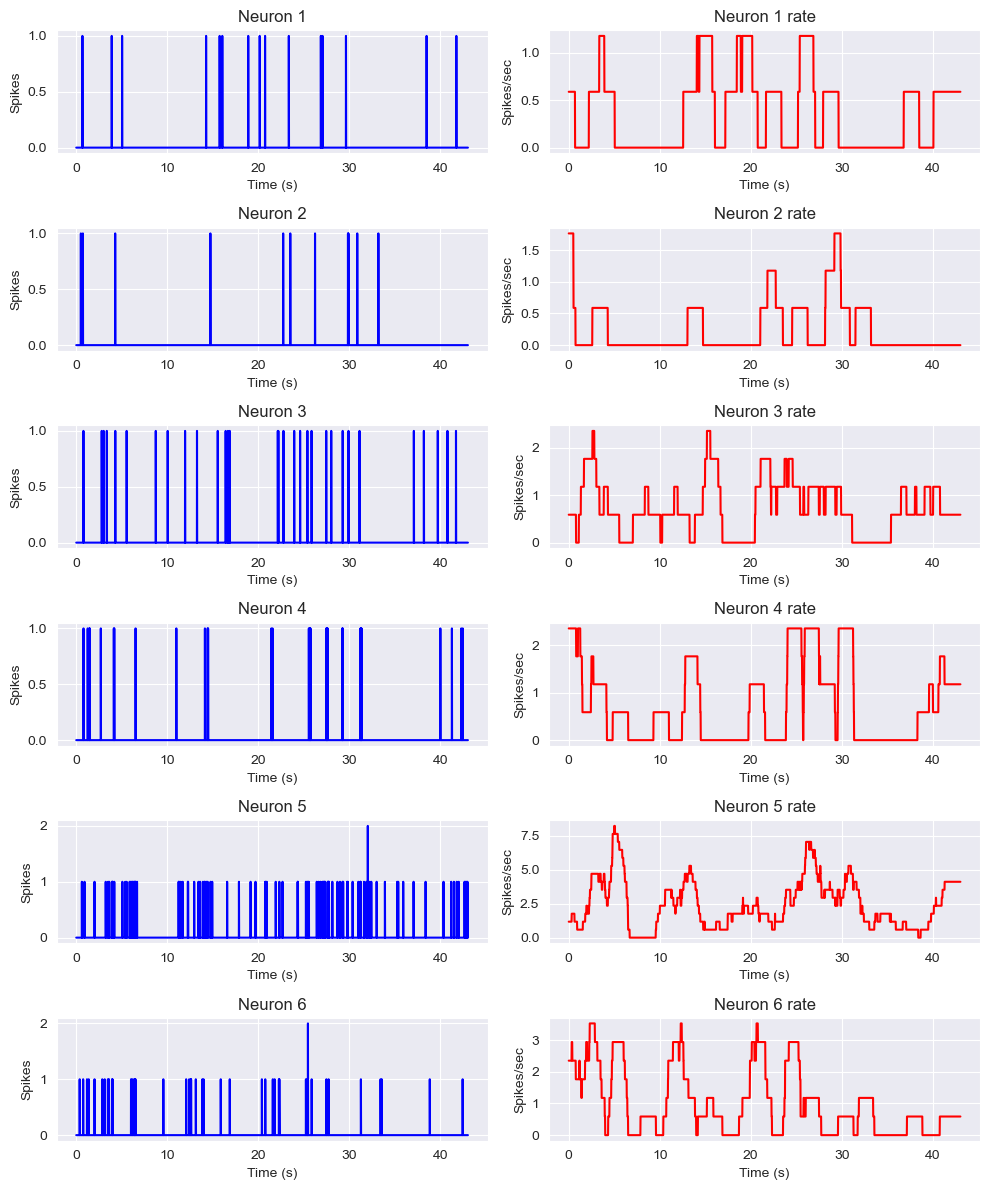

In [20]:
plot_rate()

In [143]:
from scipy.stats import pearsonr
spikes = np.loadtxt('DataSetCoursework_AMA.txt')

bin_size = 0.01
window_size= 1.7
rate, _ = rates1_calculate(spikes=spikes, window_size=window_size, bin_size=bin_size)
rate_flat = rate.flatten()
spikes = spikes[:, :-1]
spikes_flat = spikes.flatten()
correlation, p_value = pearsonr(rate_flat, spikes_flat)
print(f'Pearson Correlation Coefficient: {correlation:.3f}')
print(f'P-value: {p_value}')

Pearson Correlation Coefficient: 0.695
P-value: 0.0


> The pearson correlation between these spikes and rate for window size of 2.0 is 0.7 and p-value is 0.000 meaning the correlation is statistically significant and not due to randomness.

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
import time

def model_rate(spikes, target, window_sizes, bin_size=0.01, test_size=0.2, random_state=42):
    '''
    This function gets the model using the firing rate of the neurons at different window sizes.
    Developed By Gerald Bournemouth, and Modified by ChatGPT generative AI.
    This function calculates the model Using Linear Discriminant Analysis and get the comparison between the
    firing rate of the neurons at different window sizes to spikes with no firing rate.
    :param spikes: the spike train as numpy array
    :param target: the target column as numpy array
    :param window_sizes: the window sizes to be used
    :param bin_size: the snapshot time window
    :param test_size: a random parameter for train/test split
    :param random_state: random seed
    :return: performances and optimal window size
    '''

    performances = {}
    lda = LinearDiscriminantAnalysis()

    for window_size in window_sizes:
        rate, _ = rates1_calculate(spikes, window_size, bin_size) # get individual rate at specific window_size
        X_train, X_test, y_train, y_test = train_test_split(rate, target, test_size=test_size, random_state=random_state)

        loo = LeaveOneOut()
        start_time = time.time()
        scores = cross_val_score(lda, rate[:, :-1],target, cv=loo, scoring='accuracy')
        loo_time = time.time() - start_time

        # Model for train/test scores
        lda.fit(X_train, y_train)
        train_score = lda.score(X_train, y_train)
        test_score = lda.score(X_test, y_test)

        performances[window_size] = {
            'mean_accuracy': scores.mean(),
            'train_score': train_score,
            'test_score': test_score,
            'loo_time': loo_time
        }
        print(f'Window size : {window_size}, Mean Accuracy : {scores.mean():.3f}, '
              f'Train Accuracy : {train_score:.3f}, Test Accuracy : {test_score:.3f}, LOO Time : {loo_time:.2f}')
        print(f'Total time taken : {loo_time:.2f} seconds')
    optimal_window_size = max(performances, key=lambda k: performances[k]['test_score'])
    return performances, optimal_window_size

In [22]:
# Initializing window sizes and loading the spikes and target predicted variable to the model_rate function
window_sizes = np.arange(0.1, 2.8, 0.1)
spikes = np.loadtxt('DataSetCoursework_POG.txt')
target = spikes[:,-2].astype(int)
performances, optimal_window_size = model_rate(spikes, target, window_sizes) # Returns the performance and the optimal window sizes.

Window size : 0.1, Mean Accuracy : 0.492, Train Accuracy : 0.503, Test Accuracy : 0.511, LOO Time : 5.12
Total time taken : 5.12 seconds
Window size : 0.2, Mean Accuracy : 0.533, Train Accuracy : 0.544, Test Accuracy : 0.525, LOO Time : 4.92
Total time taken : 4.92 seconds
Window size : 0.30000000000000004, Mean Accuracy : 0.519, Train Accuracy : 0.555, Test Accuracy : 0.544, LOO Time : 5.26
Total time taken : 5.26 seconds
Window size : 0.4, Mean Accuracy : 0.551, Train Accuracy : 0.571, Test Accuracy : 0.555, LOO Time : 4.91
Total time taken : 4.91 seconds
Window size : 0.5, Mean Accuracy : 0.563, Train Accuracy : 0.593, Test Accuracy : 0.571, LOO Time : 4.86
Total time taken : 4.86 seconds
Window size : 0.6000000000000001, Mean Accuracy : 0.597, Train Accuracy : 0.632, Test Accuracy : 0.621, LOO Time : 4.89
Total time taken : 4.89 seconds
Window size : 0.7000000000000001, Mean Accuracy : 0.619, Train Accuracy : 0.652, Test Accuracy : 0.652, LOO Time : 4.92
Total time taken : 4.92 sec

In [29]:
print(f'Optimal window size : {optimal_window_size} \n performances are : {performances[optimal_window_size]}')

Optimal window size : 1.8 
 performances are : {'mean_accuracy': 0.9818815331010453, 'rf_time': 0.3337380886077881}


In [30]:
test_accuracy = [performances[i]['test_score'] for i in performances.keys()]
window_sizes = [i for i in performances.keys()]
plt.plot(window_sizes, test_accuracy)
plt.xlabel('Window size')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs Window size')
plt.show()

KeyError: 'test_score'

> As the window size increases the model testing performances also increases which shows a significant choice how the patterns have been captured by the model. But at certain point the model no longer learns from increases performance by much.
We have chosen the max performance performed by the model.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
import time
import joblib

def model_rate_1(spikes, target,windows_size,model_path, random_state=42):

    performances = {}

    kflod = KFold(n_splits=5, shuffle=True, random_state=random_state)
    best_model = None
    best_window_size = None

    for window_size in window_sizes:
        rate, _ = rates1_calculate(spikes, window_size, bin_size) # get individual rate at specific window_size

        rf = RandomForestClassifier()

        start_time = time.time()
        scores = cross_val_score(rf, rate[:, :-1],target, cv=kflod, scoring='accuracy')
        rf_time = time.time() - start_time

        performances[window_size] = {
            'mean_accuracy': scores.mean(),
            'rf_time': rf_time
        }
        print(f'Window size : {window_size}, Mean Accuracy : {scores.mean():.3f}, RF Time : {rf_time:.2f}')
        print(f'Total time taken : {rf_time:.2f} seconds')
        if best_window_size is None or scores.mean() > performances[best_window_size]['mean_accuracy']:
            rf.fit(rate[:, :-1], target)
            best_model = rf
            best_window_size = window_size
    joblib.dump(best_model, model_path)

    return performances, best_window_size

In [26]:
window_sizes = np.arange(0.1, 2.7, 0.1)
spikes = np.loadtxt('DataSetCoursework_POG.txt')
model_path = 'model_rf.pkl'
target = spikes[:,-2].astype(int)
performances, optimal_window_size = model_rate_1(spikes=spikes, target=target, windows_size=window_sizes,model_path=model_path)

Window size : 0.1, Mean Accuracy : 0.504, RF Time : 0.26
Total time taken : 0.26 seconds
Window size : 0.2, Mean Accuracy : 0.573, RF Time : 0.29
Total time taken : 0.29 seconds
Window size : 0.30000000000000004, Mean Accuracy : 0.645, RF Time : 0.29
Total time taken : 0.29 seconds
Window size : 0.4, Mean Accuracy : 0.699, RF Time : 0.31
Total time taken : 0.31 seconds
Window size : 0.5, Mean Accuracy : 0.751, RF Time : 0.35
Total time taken : 0.35 seconds
Window size : 0.6000000000000001, Mean Accuracy : 0.818, RF Time : 0.34
Total time taken : 0.34 seconds
Window size : 0.7000000000000001, Mean Accuracy : 0.860, RF Time : 0.33
Total time taken : 0.33 seconds
Window size : 0.8, Mean Accuracy : 0.882, RF Time : 0.34
Total time taken : 0.34 seconds
Window size : 0.9, Mean Accuracy : 0.893, RF Time : 0.33
Total time taken : 0.33 seconds
Window size : 1.0, Mean Accuracy : 0.909, RF Time : 0.34
Total time taken : 0.34 seconds
Window size : 1.1, Mean Accuracy : 0.929, RF Time : 0.35
Total t

In [27]:
print(f'Optimal window size : {optimal_window_size} \n performances are : {performances[optimal_window_size]}')

Optimal window size : 1.8 
 performances are : {'mean_accuracy': 0.9818815331010453, 'rf_time': 0.3337380886077881}


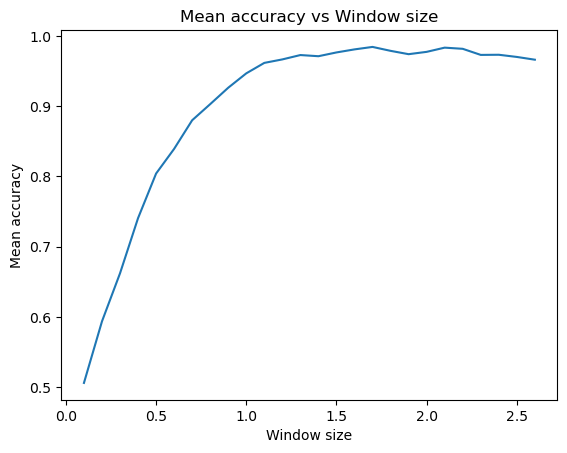

In [151]:
mean_accuracy = [performances[i]['mean_accuracy'] for i in performances.keys()]
window_sizes = [i for i in performances.keys()]
plt.plot(window_sizes, mean_accuracy)
plt.xlabel('Window size')
plt.ylabel('Mean accuracy')
plt.title('Mean accuracy vs Window size')
plt.show()

> The performance on this data is really poor under the same time window of 1.7 which had greater accuracy of 96% in training.

In [165]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d


def firing_rate_gaussian(spikes, bin_size=0.01, sigma=0.02):
    """
    Compute the firing rate using Gaussian smoothing and optionally plot the results.

    Parameters:
    - spikes (ndarray): 2D numpy array where rows represent time bins and columns represent neurons.
                        Each entry is binary (1 = spike, 0 = no spike).
    - bin_size (float): Time step of each bin in seconds.
    - sigma (float): Standard deviation of Gaussian window in seconds.

    Returns:
    - rate (ndarray): Smoothed firing rates (in spikes per second) for each neuron.
    """
    # Convert sigma from seconds to bins
    sigma_bins = sigma / bin_size

    # Apply Gaussian smoothing
    smoothed_rate = gaussian_filter1d(spikes, sigma=sigma_bins, axis=0) / bin_size

    def plot_rate():
        """
        Plot the spike train and firing rate for each neuron.
        """
        # Number of neurons
        m = spikes.shape[1]
        # Create time vector assuming bin_size
        times = np.arange(spikes.shape[0]) * bin_size

        fig, axs = plt.subplots(m, 2, figsize=(10, m * 2))  # Create subplots for all neurons
        for j in range(m):  # Loop to plot for each neuron
            # Plot spike train on the left
            axs[j, 0].plot(times, spikes[:, j], 'b')
            axs[j, 0].set_title(f'Neuron {j + 1} - Spike Train')  # Title for the subplot
            axs[j, 0].set_ylabel('Spikes')  # Y-axis label
            axs[j, 0].set_xlabel('Time (s)')  # X-axis label

            # Plot firing rate on the right
            axs[j, 1].plot(times, smoothed_rate[:, j], 'r')
            axs[j, 1].set_title(f'Neuron {j + 1} - Firing Rate')  # Title for the subplot
            axs[j, 1].set_ylabel('Spikes/sec')  # Y-axis label
            axs[j, 1].set_xlabel('Time (s)')  # X-axis label

        plt.tight_layout()  # Adjust layout for readability
        plt.show()

    # Attach plot function as a callable method of the parent function
    plot_rate.plot = plot_rate

    return smoothed_rate
